# PCA 

The goal of the project is to use a dimension reduction approach (PCA, etc.) to decompose and transform high-dimension image data into a (much) lower dimension space for classification and clustering. The dataset can be found here: https://drive.google.com/drive/folders/1FcSHxEKHIyZ_Vckh6K1GDTN-VdM7tgD6 

For each subtask listed below, find the best two eigenvectors that define a 2D space to best separate corresponding categories, visualize individual data points in a 2D plot and calculate a Silhouette score
for each subtask. <br>

Subtask 1. Emotion recognition <br>
Subtask 2. Mask detection <br>
Subtask 3. Person identification <br>

Bonus points: Instead of using a whole image, you are encouraged to try other (creative) ways to solve each problem. A better solution should have a lower Silhouette score than the default one. Even if you may not be able to implement an idea you come up with, you will earn extra points by clearly describing a new idea and explaining in what ways it may improve performance. <br>

Write a report to explain your results and summarize what you’ve learned by trying to find the best dimension reduction solution for each problem.

# Load data

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dir = '/Users/mcmahonmc/Github/machine-learning-2021/02_pca/processed/'

img_files = sorted(glob.glob(data_dir + '*.jpg'))
print('We have %.f images total' % len(img_files))

We have 112 images total


In [3]:
data = pd.DataFrame({'person': [file.split('processed/')[1].split('_')[0] for file in img_files],
                     'emotion': [file.split('processed/')[1].split('_')[1] for file in img_files],
                     'mask': [file.split('processed/')[1].split('_')[2].split('.jpg')[0] for file in img_files]})

data['emotion'] = data['emotion'].replace(['A', 'H', 'N', 'S'], ['Angry', 'Happy', 'Neutral', 'Sad'])
data['mask'] = data['mask'].replace(['M', 'N'], ['Mask', 'No Mask'])

data

person  emotion     mask
0      AMR    Angry     Mask
1      AMR    Angry  No Mask
2      AMR    Happy     Mask
3      AMR    Happy  No Mask
4      AMR  Neutral     Mask
..     ...      ...      ...
107     ZM    Happy  No Mask
108     ZM  Neutral     Mask
109     ZM  Neutral  No Mask
110     ZM      Sad     Mask
111     ZM      Sad  No Mask

[112 rows x 3 columns]

(265, 200)


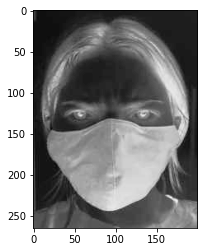

In [4]:
img0 = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
print(img0.shape)
plt.imshow(img0, cmap='Greys')

In [5]:
images = np.zeros((265,200))

for img_file in img_files:
    images = np.dstack((images, cv2.imread(img_file ,cv2.IMREAD_GRAYSCALE)))

images = images[:,:,1:]
images = np.transpose(images, (2, 0, 1))
n_samples, h, w = images.shape
print(images.shape)                

(112, 265, 200)


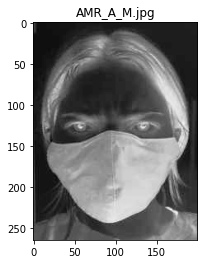

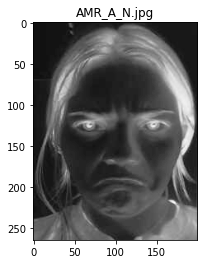

In [6]:
plt.imshow(images[0], cmap='Greys')
plt.title(img_files[0].split('processed/')[1])
plt.show()

plt.imshow(images[1], cmap='Greys')
plt.title(img_files[1].split('processed/')[1])
plt.show()

In [7]:
X = images.reshape((112,-1))
n_features = X.shape[1]

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

## Subtask 1. Emotion recognition

In [9]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  4


In [10]:
# Function to plot images in 3 * 4
def plot_gallery(images, titles, h, w, n_row = n_samples, n_col = 4):
    n_row = math.ceil(n_row/n_col)
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(str(titles[i]), size = 12)
        plt.xticks(()); plt.yticks(())


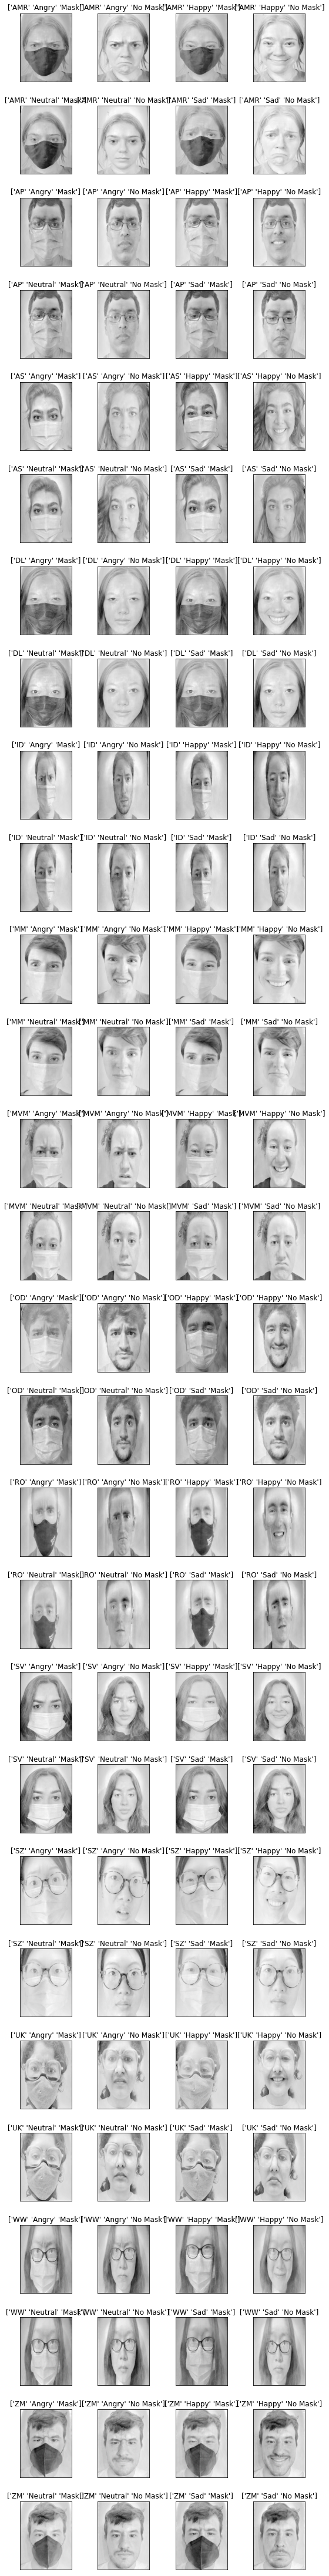

In [11]:
titles = np.array(data)
plot_gallery(X, titles, h, w)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


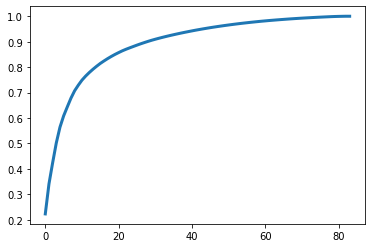

In [13]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [14]:
np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]

14

In [15]:
n_components = 14

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Projecting the input data on the eigenfaces orthonormal basis


In [16]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.08      0.17      0.11         6
       Happy       0.17      0.12      0.14         8
     Neutral       0.00      0.00      0.00         8
         Sad       0.00      0.00      0.00         6

    accuracy                           0.07        28
   macro avg       0.06      0.07      0.06        28
weighted avg       0.07      0.07      0.06        28



In [17]:
predictions

array(['Angry', 'Happy', 'Happy', 'Angry', 'Angry', 'Happy', 'Angry',
       'Sad', 'Angry', 'Angry', 'Neutral', 'Angry', 'Sad', 'Neutral',
       'Sad', 'Happy', 'Happy', 'Happy', 'Neutral', 'Angry', 'Sad',
       'Angry', 'Angry', 'Sad', 'Sad', 'Angry', 'Angry', 'Sad'],
      dtype=object)

IndexError: index 28 is out of bounds for axis 0 with size 28

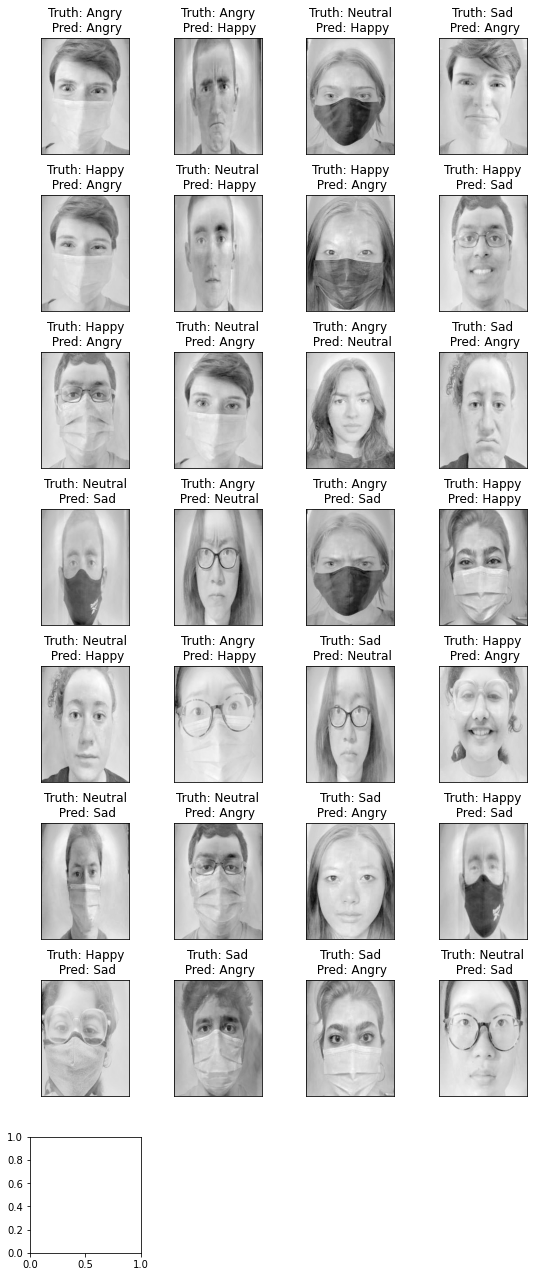

In [19]:
titles = ['Truth: %s\n Pred: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w)

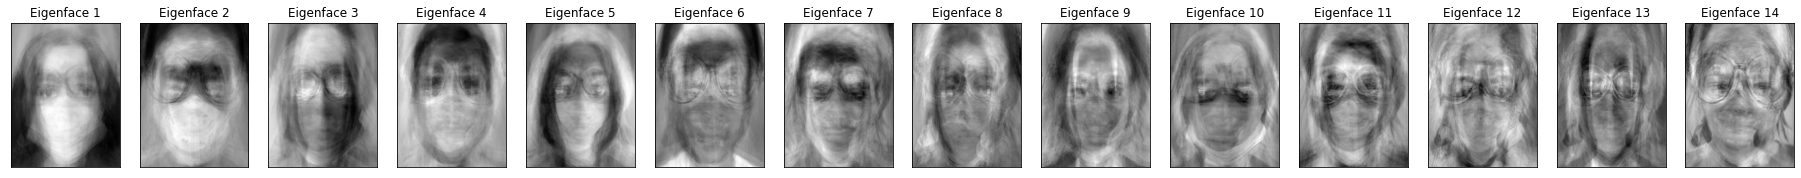

In [20]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

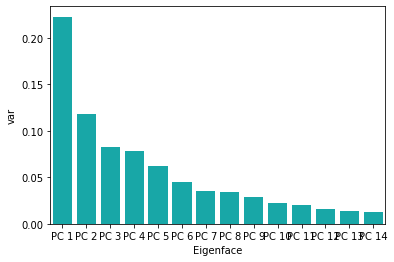

In [21]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [22]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731568 -0.086850  1.982622 -0.850632 -0.055712  1.038072   
1 -0.572764  0.494469 -0.576120 -1.034148  0.343047 -1.458497  0.337216   
2 -0.820833 -1.839789  1.660367 -1.297839 -0.775286  0.204636  0.755421   
3 -0.340118  0.450103 -1.037794  1.311259 -0.451091  0.012056 -0.594261   
4 -0.196241  0.522305 -0.184069  1.814330 -0.649042 -0.269938  1.295104   

    Eigen 8   Eigen 9  Eigen 10  Eigen 11  Eigen 12  Eigen 13  Eigen 14  \
0 -0.783030  0.252463 -0.514565  2.419581  0.035266 -0.178919 -0.750275   
1  0.655235 -0.054523 -1.032175  0.305609  0.173907  0.331243 -0.309382   
2 -0.062863 -0.010478  1.547891  0.863225 -1.854206 -0.202630 -0.024745   
3 -0.072130  0.338186 -0.899588  1.718954 -0.872880 -0.899933 -0.406459   
4 -0.817999 -0.109636 -0.573042  2.300410 -0.470816 -0.075843 -0.364648   

   Cluster  
0    Angry  
1    Angry  
2    Happy  
3    Happy  
4  Neutral

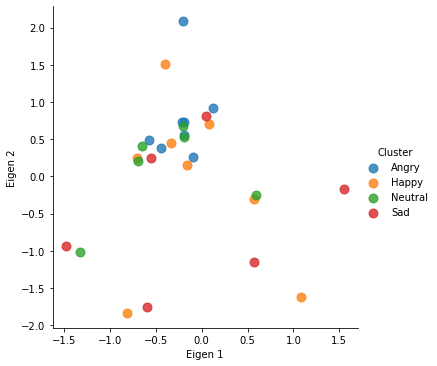

In [23]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [24]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_pca, predictions))

Silhouette Coefficient: 0.080


## Subtask 2. Mask recognition

In [43]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  2


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))

size of training Data is  84 and Testing Data is  28


In [47]:
pca = PCA().fit(X_train)

n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 14
Projecting the input data on the eigenfaces orthonormal basis


In [49]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.82      0.56      0.67        16
     No Mask       0.59      0.83      0.69        12

    accuracy                           0.68        28
   macro avg       0.70      0.70      0.68        28
weighted avg       0.72      0.68      0.68        28



IndexError: index 28 is out of bounds for axis 0 with size 28

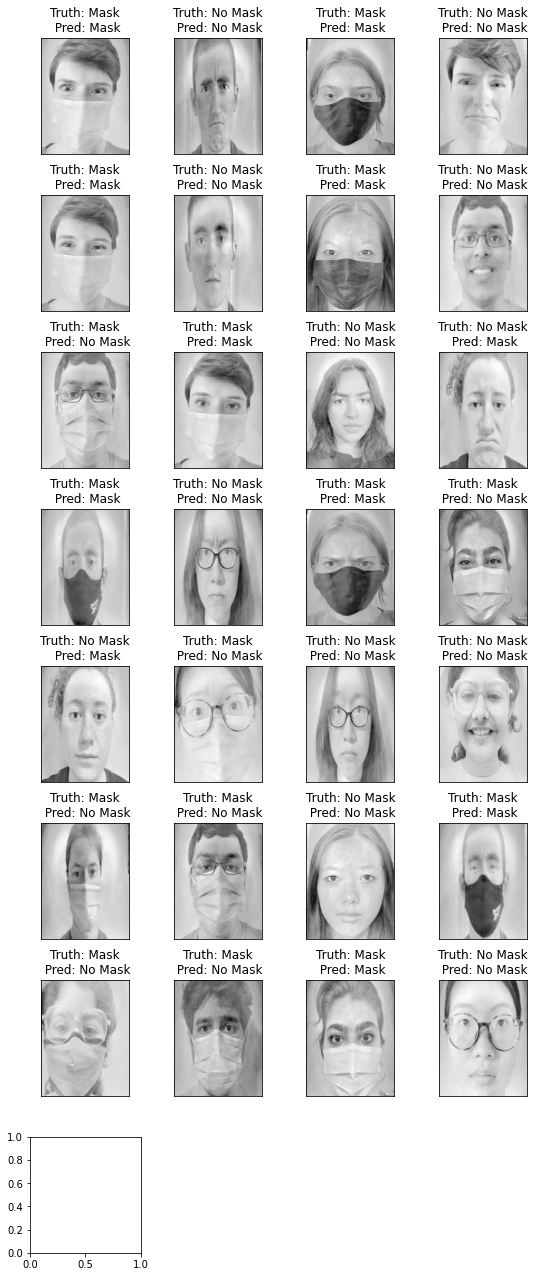

In [51]:
titles = ['Truth: %s\n Pred: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w)

In [ ]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

In [ ]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [52]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731568 -0.086849  1.982619 -0.850617 -0.055654  1.037961   
1 -0.572764  0.494469 -0.576119 -1.034149  0.343042 -1.458505  0.337085   
2 -0.820833 -1.839788  1.660366 -1.297840 -0.775289  0.204642  0.755514   
3 -0.340118  0.450103 -1.037795  1.311259 -0.451078  0.012049 -0.594420   
4 -0.196241  0.522305 -0.184069  1.814326 -0.649029 -0.269886  1.295023   

    Eigen 8   Eigen 9  Eigen 10  Eigen 11  Eigen 12  Eigen 13  Eigen 14  \
0 -0.782556  0.253042 -0.515010  2.420306  0.031257 -0.208760 -0.752151   
1  0.655031 -0.054764 -1.031875  0.305866  0.172680  0.347929 -0.320070   
2 -0.062894 -0.010741  1.547784  0.862905 -1.850419 -0.195044 -0.010013   
3 -0.071913  0.338966 -0.898320  1.720933 -0.874385 -0.917304 -0.406106   
4 -0.817645 -0.109162 -0.572888  2.301018 -0.472331 -0.095247 -0.362012   

   Cluster  
0     Mask  
1  No Mask  
2     Mask  
3  No Mask  
4     Mask

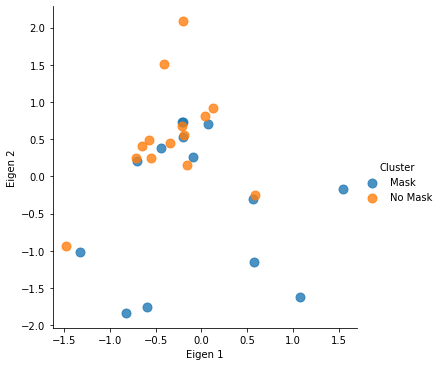

In [53]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [54]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_pca, predictions))

Silhouette Coefficient: 0.050


## Subtask 3. Person recognition

In [66]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  14


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


In [68]:
pca = PCA().fit(X_train)

n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 14
Projecting the input data on the eigenfaces orthonormal basis


In [69]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       1.00      1.00      1.00         2
          AP       1.00      1.00      1.00         3
          AS       1.00      0.50      0.67         2
          DL       1.00      1.00      1.00         2
          ID       1.00      1.00      1.00         1
          MM       1.00      1.00      1.00         4
         MVM       0.67      1.00      0.80         2
          OD       1.00      1.00      1.00         1
          RO       1.00      1.00      1.00         4
          SV       1.00      1.00      1.00         1
          SZ       1.00      1.00      1.00         2
          UK       1.00      1.00      1.00         2
          WW       1.00      1.00      1.00         2

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.98      0.96      0.96        28



IndexError: index 28 is out of bounds for axis 0 with size 28

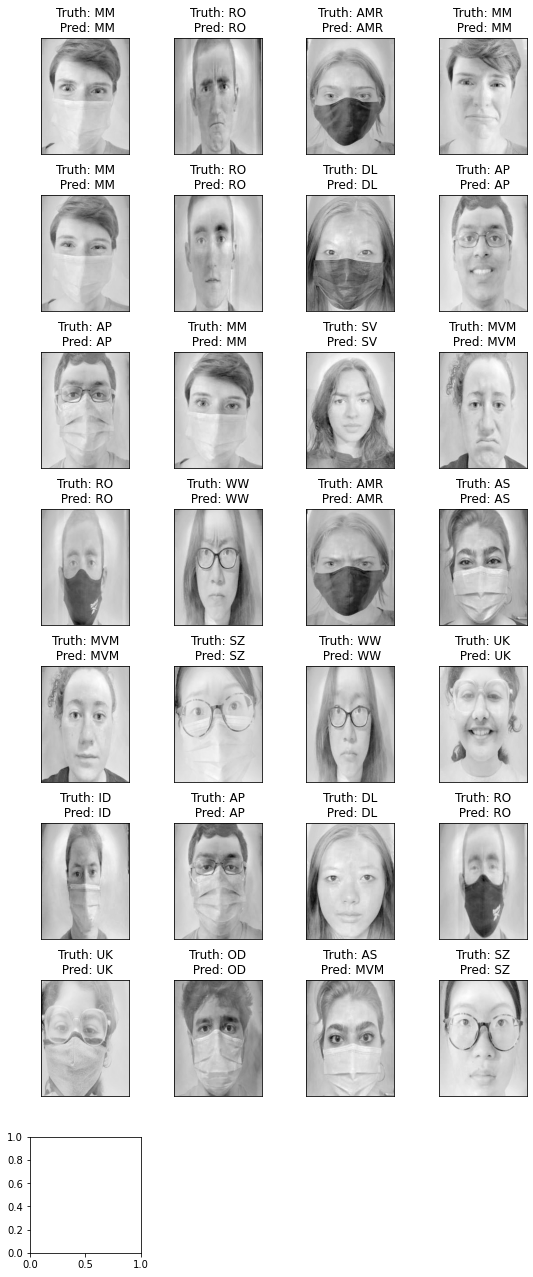

In [70]:
titles = ['Truth: %s\n Pred: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w)

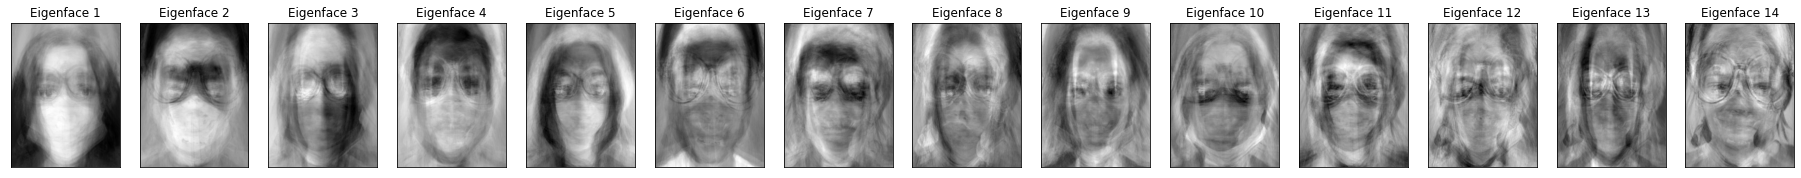

In [71]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

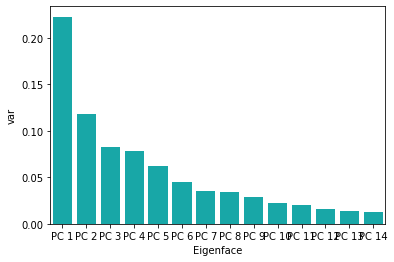

In [72]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [73]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.197991  0.731568 -0.086852  1.982623 -0.850632 -0.055672  1.037955   
1 -0.572764  0.494469 -0.576119 -1.034150  0.343046 -1.458504  0.337088   
2 -0.820833 -1.839789  1.660366 -1.297840 -0.775288  0.204635  0.755380   
3 -0.340118  0.450103 -1.037794  1.311262 -0.451083  0.012034 -0.594279   
4 -0.196241  0.522305 -0.184071  1.814330 -0.649043 -0.269896  1.294997   

    Eigen 8   Eigen 9  Eigen 10  Eigen 11  Eigen 12  Eigen 13  Eigen 14  \
0 -0.782861  0.252301 -0.514847  2.417732  0.030274 -0.168700 -0.793199   
1  0.655088 -0.054620 -1.032371  0.306285  0.169793  0.328108 -0.316325   
2 -0.062868 -0.010871  1.547384  0.861827 -1.855239 -0.198401 -0.022562   
3 -0.072013  0.338140 -0.897738  1.720339 -0.869882 -0.889582 -0.423241   
4 -0.817894 -0.109648 -0.572817  2.299328 -0.473561 -0.067110 -0.394757   

  Cluster  
0     AMR  
1     AMR  
2     AMR  
3     AMR  
4     AMR

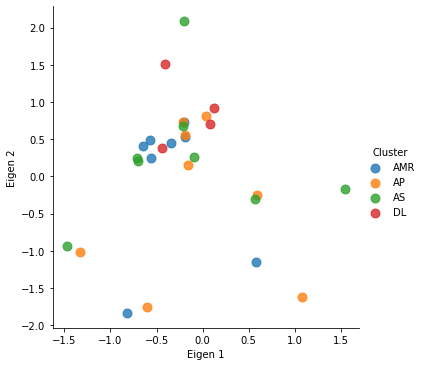

In [74]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [75]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_pca, predictions))

Silhouette Coefficient: 0.271


# Edges

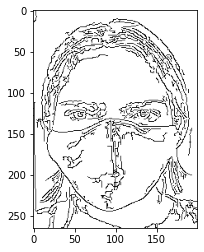

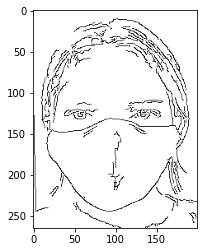

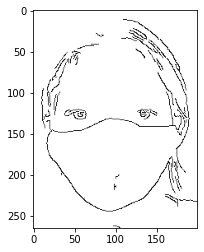

In [172]:
lower = [10, 30, 50]
upper = [50, 70, 100]

for l, u in zip(lower, upper):
    gray_image = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
    edged_image = cv2.Canny(gray_image, threshold1=l, threshold2=u)
    plt.imshow(edged_image, cmap = 'Greys')
    plt.show()

In [173]:
edged_images = np.zeros((265,200))

for img_file in img_files:
    gray_image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    edged_image = cv2.Canny(gray_image, threshold1=30, threshold2=70)
    edged_images = np.dstack((edged_images, edged_image))

edged_images = edged_images[:,:,1:]
edged_images = np.transpose(edged_images, (2, 0, 1))
n_samples, h, w = edged_images.shape
print(edged_images.shape)                

(112, 265, 200)


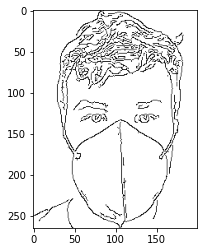

In [174]:
plt.imshow(edged_images[np.random.randint(0, edged_images.shape[2], 1)[0]], cmap = 'Greys')

In [175]:
X = edged_images.reshape((112,-1))
n_features = X.shape[1]

In [113]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## Subtask 1. Emotion recognition

In [176]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  4


In [177]:
# Function to plot images in 3 * 4
def plot_gallery(images, titles, h, w, n_row = n_samples, n_col = 4):
    n_row = math.ceil(n_row/n_col)
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =.90, hspace =.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
        plt.title(str(titles[i]), size = 12)
        plt.xticks(()); plt.yticks(())


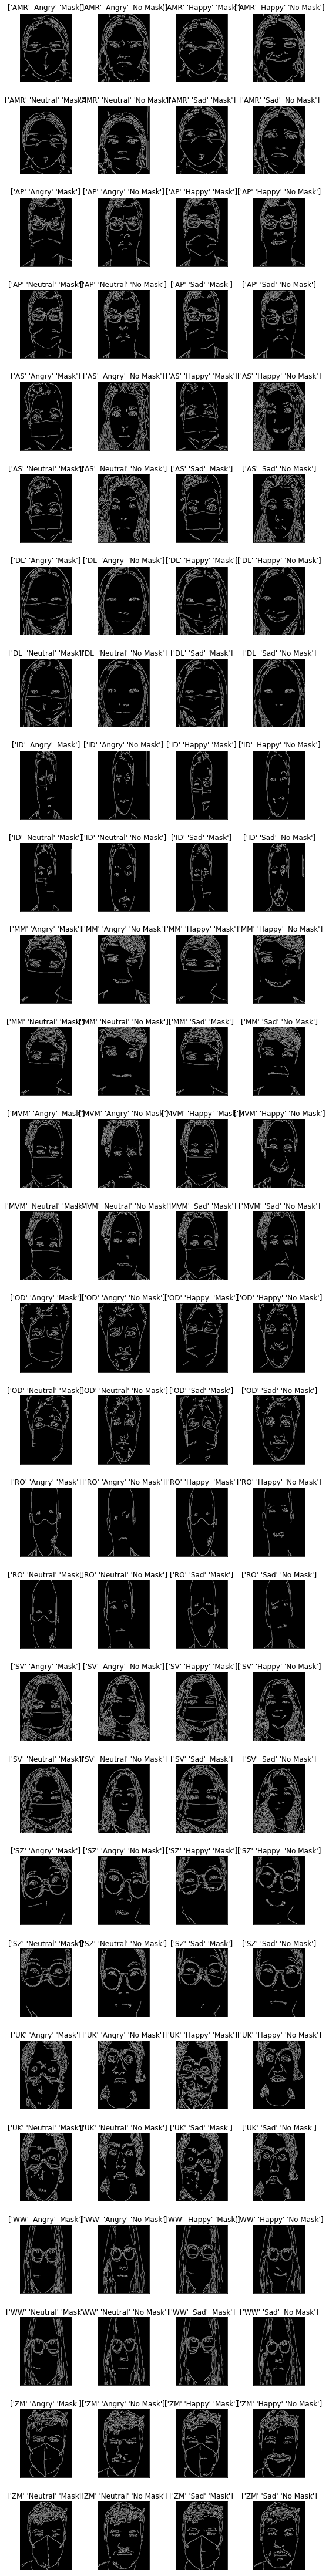

In [178]:
titles = np.array(data)
plot_gallery(X, titles, h, w)

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


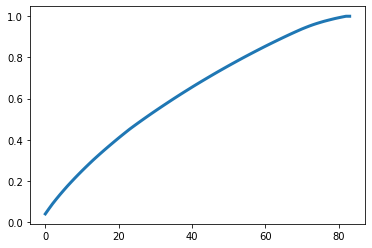

In [180]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [181]:
n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 55
Projecting the input data on the eigenfaces orthonormal basis


In [182]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         6
       Happy       0.32      0.75      0.44         8
     Neutral       0.00      0.00      0.00         8
         Sad       0.12      0.17      0.14         6

    accuracy                           0.25        28
   macro avg       0.11      0.23      0.15        28
weighted avg       0.12      0.25      0.16        28



In [183]:
predictions

array(['Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy', 'Happy',
       'Sad', 'Sad', 'Sad', 'Happy', 'Angry', 'Happy', 'Happy', 'Happy',
       'Happy', 'Happy', 'Sad', 'Happy', 'Happy', 'Sad', 'Sad', 'Happy',
       'Happy', 'Happy', 'Sad', 'Happy', 'Sad'], dtype=object)

IndexError: index 28 is out of bounds for axis 0 with size 28

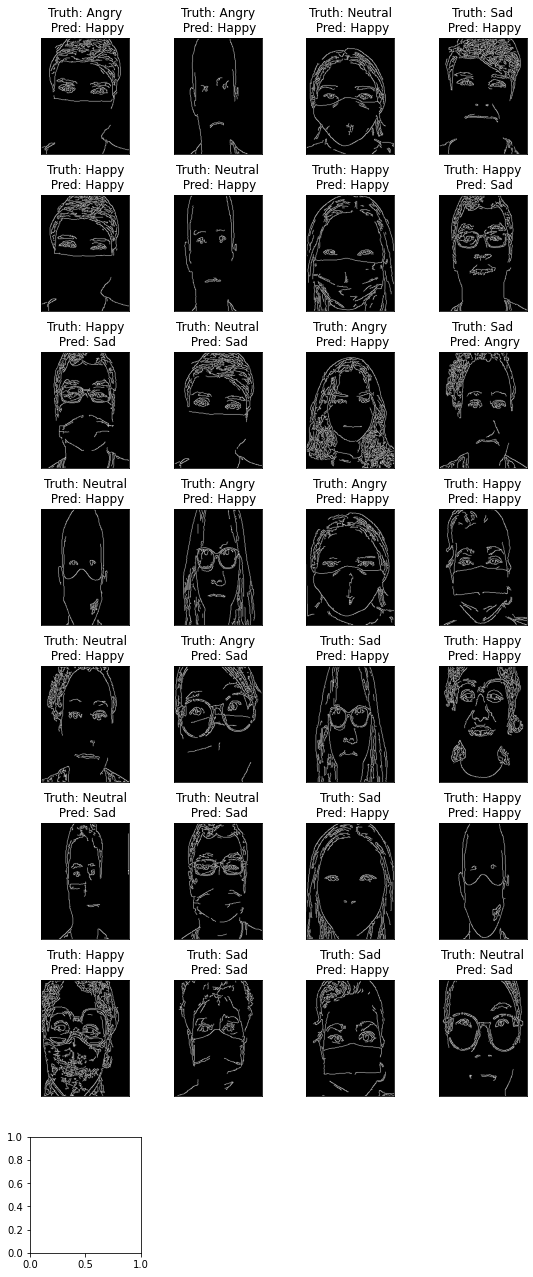

In [184]:
titles = ['Truth: %s\n Pred: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w)

In [ ]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

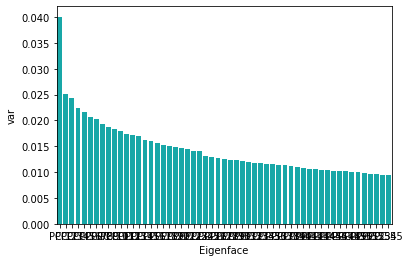

In [185]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [186]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.285898 -0.612401 -0.331988 -0.065646  0.199570 -0.330940 -0.101218   
1 -0.787345  0.623724 -0.179029  0.285774 -0.286796  0.133320  0.085245   
2  0.042289  0.349390 -0.081394 -0.375987  0.095433  0.418796  0.218574   
3 -0.294433 -0.965109 -0.229914 -0.059428  0.426248 -0.345572  0.080415   
4 -0.234631 -0.555389 -0.448757 -0.103135  0.259410 -0.356491  0.003037   

    Eigen 8   Eigen 9  Eigen 10  ...  Eigen 47  Eigen 48  Eigen 49  Eigen 50  \
0  0.256321  0.274798 -0.115360  ... -0.006515  0.190337  0.043230  0.020134   
1 -0.086019 -0.031903  0.153113  ... -0.149739 -0.036741  0.058705 -0.013756   
2  0.063910 -0.268075 -0.131668  ... -0.072837  0.238600  0.187645  0.173923   
3  0.179161  0.364059  0.078615  ...  0.039774  0.113125 -0.097562  0.122360   
4  0.246358  0.335012 -0.094350  ...  0.032395  0.092364  0.047767  0.063125   

   Eigen 51  Eigen 52  Eigen 53  Eigen 54  Eigen 55  Cluster  
0  0.068751 -0.186744  0.034141  0.132547 -0.102889    Angry  
1  0.025298 -0.136049  0.095740 -0.195691  0.167284    Angry  
2 -0.095436 -0.186406 -0.004821 -0.252026 -0.025946    Happy  
3  0.162535  0.001320  0.009962  0.044147 -0.028163    Happy  
4  0.159462 -0.230652  0.041515 -0.016791 -0.053886  Neutral  

[5 rows x 56 columns]

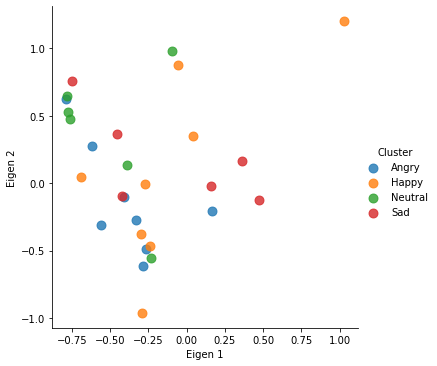

In [187]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [188]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_pca, predictions))

Silhouette Coefficient: -0.044


## Subtask 2. Mask recognition

In [189]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  2


In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


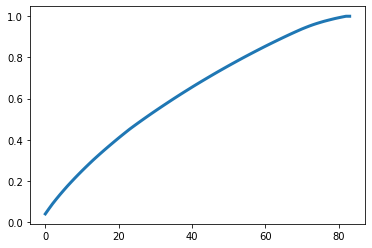

In [191]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [192]:
n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 55
Projecting the input data on the eigenfaces orthonormal basis


In [193]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.64      1.00      0.78        16
     No Mask       1.00      0.25      0.40        12

    accuracy                           0.68        28
   macro avg       0.82      0.62      0.59        28
weighted avg       0.79      0.68      0.62        28



In [194]:
predictions

array(['Mask', 'Mask', 'Mask', 'No Mask', 'Mask', 'Mask', 'Mask', 'Mask',
       'Mask', 'Mask', 'No Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'No Mask'], dtype=object)

IndexError: index 28 is out of bounds for axis 0 with size 28

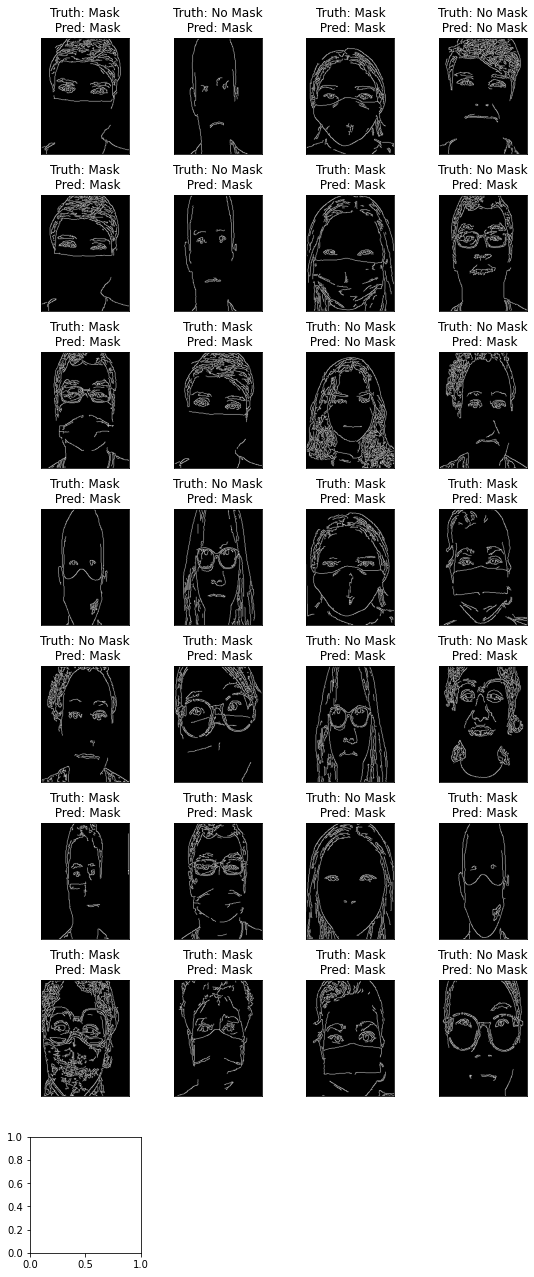

In [195]:
titles = ['Truth: %s\n Pred: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w)

In [ ]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

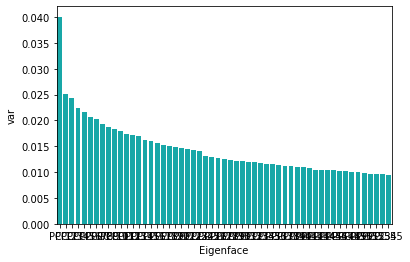

In [196]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [197]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.285874 -0.613683 -0.332424 -0.067510  0.198999 -0.328393 -0.099424   
1 -0.787224  0.623778 -0.178871  0.285813 -0.289382  0.132730  0.086283   
2  0.042309  0.349467 -0.081009 -0.375691  0.095500  0.419663  0.218592   
3 -0.294374 -0.966566 -0.230595 -0.060929  0.427873 -0.344891  0.081594   
4 -0.234535 -0.556851 -0.449433 -0.104493  0.258487 -0.352969  0.004316   

    Eigen 8   Eigen 9  Eigen 10  ...  Eigen 47  Eigen 48  Eigen 49  Eigen 50  \
0  0.255781  0.277540 -0.113257  ... -0.027492  0.055906  0.053978  0.068129   
1 -0.085638 -0.033811  0.151115  ...  0.051637 -0.143324 -0.133246 -0.047891   
2  0.062733 -0.267236 -0.132085  ... -0.177553  0.101254 -0.181117  0.030267   
3  0.177876  0.362018  0.077935  ... -0.079746  0.088873  0.028111  0.141001   
4  0.247520  0.335473 -0.092533  ... -0.082638 -0.022217 -0.023745  0.149621   

   Eigen 51  Eigen 52  Eigen 53  Eigen 54  Eigen 55  Cluster  
0  0.148947  0.285282  0.001810  0.120939  0.106847     Mask  
1  0.188427 -0.156759 -0.128503  0.017449  0.047177  No Mask  
2  0.057411 -0.052666  0.062570 -0.217713  0.041019     Mask  
3  0.173212  0.030552 -0.068201 -0.021520 -0.100021  No Mask  
4  0.155199  0.243333  0.068957  0.021914  0.104916     Mask  

[5 rows x 56 columns]

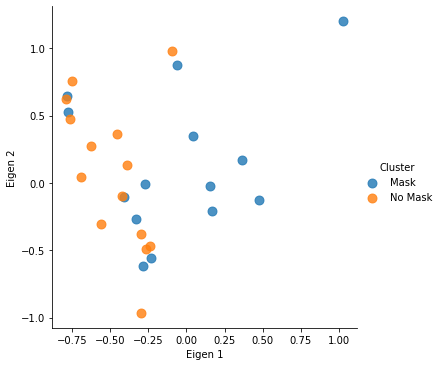

In [198]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [199]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_pca, predictions))

Silhouette Coefficient: 0.112


## Subtask 3. Person recognition

In [200]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  112
Size of a data sample:  53000
Number of Class Labels:  14


In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  84 and Testing Data is  28


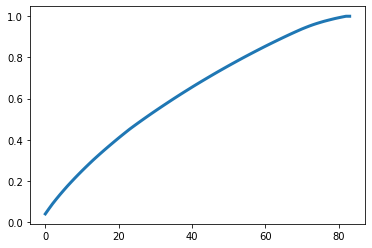

In [202]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [203]:
n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 55
Projecting the input data on the eigenfaces orthonormal basis


In [204]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       0.00      0.00      0.00         2
          AP       0.00      0.00      0.00         3
          AS       0.00      0.00      0.00         2
          DL       0.00      0.00      0.00         2
          ID       0.04      1.00      0.07         1
          MM       0.00      0.00      0.00         4
         MVM       0.00      0.00      0.00         2
          OD       0.00      0.00      0.00         1
          RO       0.00      0.00      0.00         4
          SV       0.00      0.00      0.00         1
          SZ       0.00      0.00      0.00         2
          UK       0.00      0.00      0.00         2
          WW       0.00      0.00      0.00         2

    accuracy                           0.04        28
   macro avg       0.00      0.08      0.01        28
weighted avg       0.00      0.04      0.00        28



In [205]:
predictions

array(['ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID',
       'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID', 'ID',
       'ID', 'ID', 'ID', 'ID', 'ID', 'ID'], dtype=object)

IndexError: index 28 is out of bounds for axis 0 with size 28

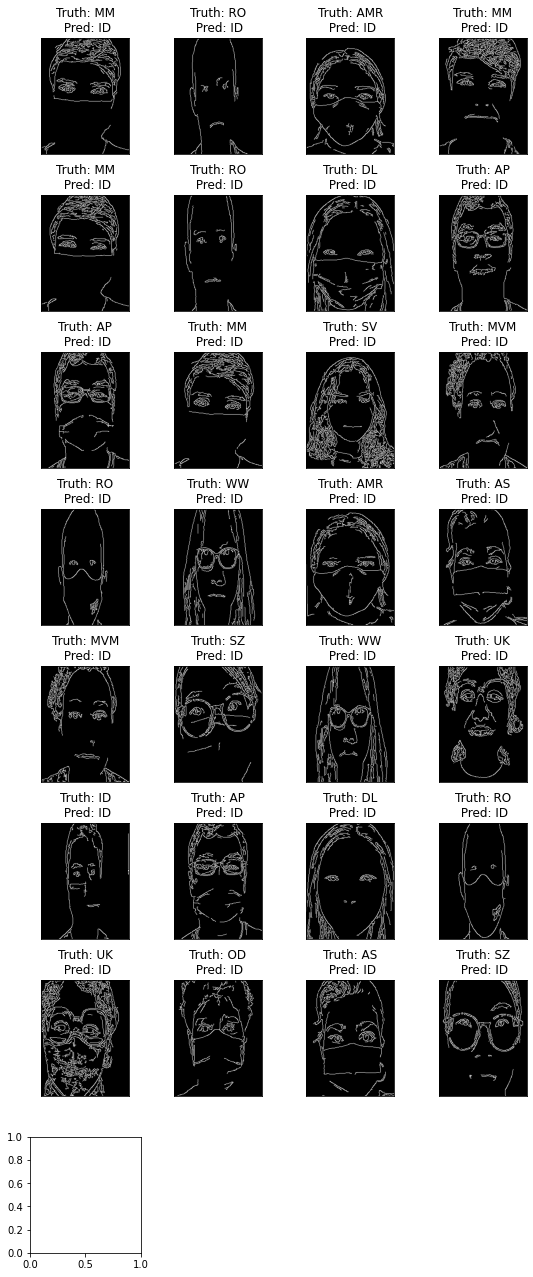

In [206]:
titles = ['Truth: %s\n Pred: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w)

In [ ]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

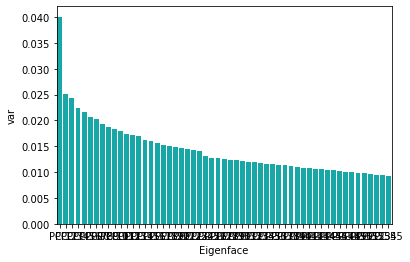

In [207]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [208]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4   Eigen 5   Eigen 6   Eigen 7  \
0 -0.285915 -0.613266 -0.332241 -0.066936  0.200336 -0.326871 -0.100584   
1 -0.787299  0.623678 -0.179366  0.286086 -0.287254  0.135579  0.088625   
2  0.042282  0.349842 -0.081611 -0.375037  0.096083  0.418741  0.217579   
3 -0.294395 -0.966037 -0.230258 -0.060780  0.427849 -0.344722  0.080122   
4 -0.234603 -0.555857 -0.449488 -0.103918  0.257951 -0.354156  0.001913   

    Eigen 8   Eigen 9  Eigen 10  ...  Eigen 47  Eigen 48  Eigen 49  Eigen 50  \
0  0.253729  0.277998 -0.120355  ... -0.215981  0.052127 -0.025025 -0.125453   
1 -0.085274 -0.027636  0.152403  ... -0.051191  0.086180 -0.098097 -0.154067   
2  0.064228 -0.266808 -0.133476  ... -0.075771  0.123998 -0.193168 -0.264084   
3  0.177683  0.361623  0.074886  ... -0.019815 -0.003273  0.100254 -0.166114   
4  0.245987  0.333943 -0.097879  ... -0.077474 -0.043302 -0.079838 -0.205733   

   Eigen 51  Eigen 52  Eigen 53  Eigen 54  Eigen 55  Cluster  
0 -0.166817  0.171070  0.122307  0.310426  0.052443      AMR  
1  0.092915  0.016519 -0.159953  0.021345 -0.184047      AMR  
2  0.048217  0.058138 -0.047384 -0.016535 -0.101417      AMR  
3 -0.145099 -0.009576 -0.025472  0.065510  0.157242      AMR  
4 -0.164488  0.163095  0.014168  0.199944 -0.131636      AMR  

[5 rows x 56 columns]

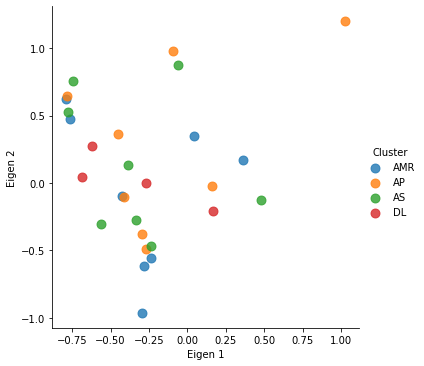

In [209]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [210]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_test_pca, predictions))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)